#### Project Description


Solar energy plays a crucial role in reducing greenhouse gas emissions and meeting rising energy demands. Information on building roof types and geometry is essential for assessing solar potential, improving energy efficiency, and supporting energy transition policies. Roof material and shape data also can inform studies on thermal efficiency, roof durability, disaster risk, heritage conservation, urban heat, and more.

This study aims to develop a ready-to-use, AI-ready open dataset containing building roof types and geometry, along with a scalable pipeline for roof material classification. The dataset is created using OpenStreetMap (OSM) roof material labels and high-resolution satellite imagery obtained from [OpenAerialMap](https://map.openaerialmap.org/#/7.164459228515626,50.84562199133437,12/square/12020303222/617970f8800b10000509eda7?_k=h73n1n), originally from the Maxar [Open Data Program](https://www.maxar.com/open-data), leveraging OSM building outlines to avoid computationally expensive segmentation processes. This notebook includes the code to obtain and preprocess this data, which can be used to transform any geospatial dataset into the YOLO dataset format, in addition to training a model.

To demonstrate the dataset’s applicability, a convolutional neural network (CNN) model, specifically, Ultralytics' YOLOv11, is used to classify roofs into categories such as roof tiles, tar paper, and metal, followed by an evaluation of the model’s performance.

#### Step 0: Ensure dependencies

In [1]:
%pip install pyyaml numpy geopandas matplotlib rasterio shapely opencv-python overpy ultralytics albumentations

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, yaml, random, cv2, overpy, copy, itertools
import numpy as np
import geopandas as gpd
import matplotlib as plt
import rasterio
from rasterio.windows import Window
from shapely.geometry import box, Polygon
from pathlib import Path
import albumentations as A
#update sample with these new imports
from ultralytics import YOLO


In [6]:
import os

folder_path = 'datasets/bonn_dataset_shape_70/labels/val/'
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"Number of files: {file_count}")

Number of files: 329


#### Step 1: Data Collection and Preprocessing

First, we query all the roofs that have a roof:material OpenStreetMap(OSM) tag in the study area. We will be using the Overpass API, which allows us to fetch data from OSM. More information about the Overpass API query language and other examples can be found here: https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_API_by_Example.

We recommend using taginfo's regional databases to get a better understanding of where OpenStreetMap Data you are looking for exists https://taginfo.geofabrik.de/. 

In [4]:
import overpy

def query_osm(bbox: tuple[float, float, float, float]) -> list[dict[str, int|str|list[tuple[float, float]]]]:
    """
    Queries OpenStreetMap (OSM) using Overpass API for buildings within a given bounding box
    that have roof material data.

    Args:
        bbox (tuple[float, float, float, float]): Bounding box coordinates in the format 
            (min_latitude, min_longitude, max_latitude, max_longitude).

    Returns:
        list[dict[str, int | str | list[tuple[float, float]]]]: A list of dictionaries where each dictionary represents a building.
            Each dictionary contains:
            - "id" (int): OSM way ID.
            - "roof_material" (str): Roof material type or "unknown" if not specified.
            - "geometry" (list[tuple[float, float]]): List of (longitude, latitude) tuples 
              representing the building's outline.
    """
    api = overpy.Overpass()
    query = f"""
[out:json][timeout:180];
(
way["building"]["roof:material"]{bbox};
);
out body;
>;
out skel qt;
"""

    response = api.query(query)

    bldgs = []
    for way in response.ways:
        building = {
        "id": way.id,
        "roof_material": way.tags.get("roof:material", "unknown"),
        "geometry": [(float(node.lon), float(node.lat)) for node in way.nodes]
        #shapely expects longitude, latitude, in addition to GeoJSONs, even though WGS894 uses latitude, longitude
    }
        bldgs.append(building)
    return bldgs

# change the bounding box coordinates to get data from your desired study area (min latitude, min longitude, max latitude, max longitude)
bbox = (50.47044, 7.04552, 50.917936, 7.271421)
# Cologne: 49.97138, 6.69497, 51.02720390596486, 6.907890818310556
# Bonn: 50.47044, 7.04552, 50.917936, 7.271421
# Meckenheim: 50.13682, 6.90614, 50.5464, 7.0739
buildings_material = query_osm(bbox)

print(f"total buildings queried: {len(buildings_material)}")
print(f"first 4 buildings: {buildings_material[0:3]}")

total buildings queried: 19375
first 4 buildings: [{'id': 22376701, 'roof_material': 'roof_tiles', 'geometry': [(7.1748783, 50.8147237), (7.1749393, 50.8144985), (7.1748001, 50.8144834), (7.1747545, 50.8146516), (7.1747391, 50.8147086), (7.1748783, 50.8147237)]}, {'id': 22679422, 'roof_material': 'tar_paper', 'geometry': [(7.1582354, 50.8127516), (7.1582094, 50.8127861), (7.1577939, 50.8126591), (7.157824, 50.8126201), (7.157807, 50.8126066), (7.1578146, 50.8125957), (7.1578082, 50.8125928), (7.157812, 50.8125864), (7.1577886, 50.8125731), (7.1577803, 50.8125757), (7.1577763, 50.812571), (7.1577852, 50.812568), (7.1577767, 50.8125463), (7.1577662, 50.8125459), (7.1577669, 50.81254), (7.1577767, 50.8125404), (7.1577924, 50.8125227), (7.157785, 50.812518), (7.1577923, 50.8125136), (7.1577991, 50.8125181), (7.1578275, 50.8125085), (7.1578268, 50.8125011), (7.157838, 50.8125002), (7.1578383, 50.8125072), (7.1578711, 50.8125086), (7.157875, 50.8125035), (7.1578838, 50.8125041), (7.1578926, 

In [5]:
def create_building_material_gdf(buildings):
    """
    Creates a GeoDataFrame from a list of building data, standardizes roof material labels,
    filters out rare categories, and saves the data as GeoJSON files.

    Args:
        buildings (list[dict[str, int | str | list[tuple[float, float]]]]): A list of dictionaries representing buildings,
            each containing:
            - "id" (int): The OSM way ID.
            - "roof_material" (str): The type of roof material.
            - "geometry" (list[tuple[float, float]]): List of (longitude, latitude) tuples.

    Returns:
        gpd.GeoDataFrame: Filtered GeoDataFrame containing buildings with more common roof materials.
    """
    geometries = [Polygon(building["geometry"]) for building in buildings]
    roof_materials = [building["roof_material"] for building in buildings]

    gdf = gpd.GeoDataFrame({"roof_material": roof_materials}, geometry=geometries)
    gdf.set_crs(epsg=4326, inplace=True)

    # filter roof categories to ensure 
    category_counts = gdf["roof_material"].value_counts()
    keep_materials = category_counts[category_counts > 10].index.tolist()
    gdf_filtered = gdf[gdf['roof_material'].isin(keep_materials)]

    output_file = "bonn_buildings.geojson"
    gdf.to_file(output_file, driver="GeoJSON")

    output_file_filtered = "bonn_buildings_filtered.geojson"
    gdf_filtered.to_file(output_file_filtered, driver="GeoJSON")
    return gdf_filtered

gdf_filtered = create_building_material_gdf(buildings_material)
print(gdf_filtered['roof_material'].value_counts())


roof_material
roof_tiles    13438
tar_paper      5520
metal           109
wood             70
eternit          49
gravel           45
glass            33
grass            32
concrete         28
slate            21
sheet            14
Name: count, dtype: int64


After saving the queried OpenStreetMap data to a GeoJSON, we manually align the data and fix incorrect labels in QGIS. For the purpose of the sample dataset demonstration, we will just use the GeoJSON that was just generated.

#### Step 2: Create AI-Ready Dataset
In this step, we present a general Python module to create a training dataset in the [Ultralytics YOLO instance segementation dataset format](https://docs.ultralytics.com/datasets/segment/) from geospatial data, saved to the notebook's directory. This involves slicing the input raster image into overlapping patches and generating corresponding label files based on the roof material polygons from the GeoJSON. Each patch is filtered to ensure it contains a minimum number of labeled buildings. For valid patches, the building footprints are clipped, normalized, and saved in YOLO segmentation format. The dataset is then automatically split into training, validation, and test sets, and saved in a structured format. A YAML configuration file is also created to define the dataset structure and class labels for use during model training.

We provide the option to input a GeoJSON of all OSM buildings (regardless of whether they have a roof:shape or roof:material tag) to better filter patches--instead of taking a flat value of minimum labels per patch, patches are valid if more than a certain percentage of the buildings in them have a label. The code to generate a GeoJSON of all buildings in the bounding box is provided in the code block right above.

Note that the sample dataset is extremely unbalanced and does not include the other 4 notable roof classes. After saving the queried OpenStreetMap data to a GeoJSON, we manually aligned the data and fixed incorrect labels in QGIS. For the purpose of the sample dataset demonstration, we will use the GeoJSON that was just generated.

In [18]:
class RoofMaterialDatasetConverter:
    """
    Converts geospatial roof material annotations and aerial imagery into a YOLO-compatible
    instance segmentation dataset.

    This class handles patch extraction from a raster image, filters for regions with
    sufficient labeled data, clips roof polygons to patch boundaries, and normalizes them
    into the YOLO format. It also supports automatic train/validation/test splitting
    and exports the full dataset in the appropriate directory structure.

    Attributes:
        geojson_path (str): Path to the GeoJSON file containing labeled roof material polygons.
        raster_path (str): Path to the aerial imagery raster file.
        output_dir (str): Directory to save the generated dataset.
        patch_size (int): Height and width (in pixels) of square image patches.
        overlap (int): Number of pixels patches should overlap during extraction.
        patch_min_buildings (int): Minimum number of labeled roofs required in a patch (if no full building set provided).
        all_buildings_path (str | None): Optional GeoJSON path for all buildings (used to compute labeling completeness).
        patch_min_pct_labeled (float): Minimum percentage of labeled buildings required per patch if `all_buildings_path` is used.

    Usage:
        converter = RoofMaterialDatasetConverter(...)
        converter.generate_patches()
        converter.create_dataset_yaml()

    Raises:
        AssertionError: If CRS (coordinate reference systems) between data sources do not match.
    """
    def __init__(self, 
                 geojson_path: str, 
                 raster_path: str, 
                 output_dir: str, 
                 patch_size: int = 384, 
                 overlap: int = 96,
                 patch_min_buildings: int = 3,
                 all_buildings_path: str | None = None,
                 patch_min_pct_labeled: float = 0.7) -> None:

        self.gdf = gpd.read_file(geojson_path)
        self.raster = rasterio.open(raster_path)
        self.all_buildings = gpd.read_file(all_buildings_path)
        self.all_buildings_exist = all_buildings_path
        assert self.gdf.crs == self.all_buildings.crs == self.raster.crs

        
        self.output_dir = output_dir
        
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
            os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)
        
        self.patch_size = patch_size
        self.overlap = overlap
        self.patch_min_buildings = patch_min_buildings
        self.patch_min_pct_labeled = patch_min_pct_labeled

        self.class_mapping = {
            'gabled': 0,
            'flat': 1,
            'hipped': 2,
            'skillion': 3,
            'gambrel': 4,
            'half-hipped': 5,
            'pyramidal': 6,
            'mansard': 7
        }
        # self.class_mapping = {
        #     'roof_tiles': 0,
        #     'tar_paper': 1,
        #     'metal': 2,
        #     'concrete': 3,
        #     'tile': 4,
        #     'gravel': 5,
        #     'glass': 6
        # }

    def generate_patches(self, 
                     train_ratio: float = 0.7, 
                     val_ratio: float = 0.15, 
                     random_state: int = 42) -> dict[str, list[tuple[str, str]]]:
        """
        Generate image patches with corresponding roof material labels.
        
        Returns:
            list of tuples: [(image_path, label_path), ...]
        """
        rng = np.random.default_rng(random_state)

        # collect all potential patches
        all_patches: list[tuple[str, str]] = []
        
        height, width = self.raster.height, self.raster.width
        for y in range(0, height, self.patch_size - self.overlap):
            for x in range(0, width, self.patch_size - self.overlap):
                window = Window(x, y, self.patch_size, self.patch_size)
                
                # read patch from raster
                try:
                    patch = self.raster.read(window=window)
                    patch = np.transpose(patch[:3], (1, 2, 0))  # transpose to HWC
                except Exception as e:
                    print(f"Skipping patch at ({x},{y}) due to error: {e}")
                    continue
                
                # check if patch contains any roof material labels
                patch_bounds = box(
                    self.raster.xy(y, x)[0], 
                    self.raster.xy(y, x)[1],
                    self.raster.xy(y + self.patch_size, x + self.patch_size)[0],
                    self.raster.xy(y + self.patch_size, x + self.patch_size)[1]
                )
                
                # filter roof polygons within this patch
                patch_roofs = self.gdf[self.gdf.intersects(patch_bounds)]
                if self.all_buildings_exist:
                    patch_all_buildings = self.all_buildings[self.all_buildings.intersects(patch_bounds)]
                    if len(patch_roofs) >= len(patch_all_buildings) * self.patch_min_pct_labeled:
                        label_content = self._generate_labels(patch_roofs, patch_bounds)
                        if label_content:
                            all_patches.append((patch, (y, x), label_content))                     
                else:
                    if len(patch_roofs) >= self.patch_min_buildings:
                        label_content = self._generate_labels(patch_roofs, patch_bounds)
                        if label_content:
                            all_patches.append((patch, (y, x), label_content))
        
        # randomly split patches
        n_patches = len(all_patches)
        train_size = int(n_patches * train_ratio)
        val_size = int(n_patches * val_ratio)
        
        rng.shuffle(all_patches)
        
        train_patches = all_patches[:train_size]
        val_patches = all_patches[train_size:train_size+val_size]
        test_patches = all_patches[train_size+val_size:]
        
        split_paths = {
            'train': [],
            'val': [],
            'test': []
        }
        
        for split, patches in [('train', train_patches), ('val', val_patches), ('test', test_patches)]:
            for patch, (y, x), label_content in patches:
                patch_filename = f'patch_{y}_{x}.png'
                
                img_path = os.path.join(self.output_dir, 'images', split, patch_filename)
                label_path = os.path.join(self.output_dir, 'labels', split, patch_filename.replace('.png', '.txt'))
                
                os.makedirs(os.path.dirname(img_path), exist_ok=True)
                os.makedirs(os.path.dirname(label_path), exist_ok=True)
                
                cv2.imwrite(img_path, cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))
                
                with open(label_path, 'w') as f:
                    f.write('\n'.join(label_content))
                split_paths[split].append((img_path, label_path))
        
        return split_paths

    def _generate_labels(self, 
                         roof_polygons: gpd.GeoDataFrame,
                         patch_bounds: box) -> list[str]:
        """
        Generate YOLO segmentation labels for roof polygons in a patch.
        
        Parameters:
            roof_polygons : GeoDataFrame
                GeoDataFrame of roof polygons in the current patch
            patch_bounds : shapely.geometry.box
                Bounding box of the current patch
        
        Returns:
            list of label strings
        """
        labels: list[str] = []
        
        for _, roof in roof_polygons.iterrows():
            # only include specified roof material classes
            class_name = roof['roof_shape']
            if class_name not in self.class_mapping:
                continue
            class_index = self.class_mapping[class_name]
            
            # clip polygon to patch bounds
            clipped_roof = roof.geometry.intersection(patch_bounds)
            
            if not clipped_roof.is_empty:
                try:
                    coords = np.array(clipped_roof.exterior.coords)
                    normalized_coords = self._normalize_coordinates(coords, patch_bounds)
                    
                    if len(normalized_coords) >= 3:
                        # create label string: class_index x1 y1 x2 y2 ...
                        label = f"{class_index} " + " ".join(map(str, normalized_coords.flatten()))
                        labels.append(label)
                except Exception as e:
                    print(f"Error processing roof polygon: {e}")
        
        return labels
    
    def _normalize_coordinates(self, 
                               coords: np.ndarray, 
                               patch_bounds: box) -> np.ndarray:
        """
        Normalize polygon coordinates to 0-1 range within patch.
        
        Parameters:
            coords: numpy.ndarray
                Original polygon coordinates
            patch_bounds : shapely.geometry.box
                Bounding box of the current patch
        
        Returns:
            numpy.ndarray of normalized coordinates
        """
        x_min, y_min = patch_bounds.bounds[0], patch_bounds.bounds[1]
        x_max, y_max = patch_bounds.bounds[2], patch_bounds.bounds[3]
        normalized_coords = coords.copy()
        normalized_coords[:, 0] = (coords[:, 0] - x_min) / (x_max - x_min)
        #normalized_coords[:, 1] = (coords[:, 1] - y_min) / (y_max - y_min)
        normalized_coords[:, 1] = (y_max - coords[:, 1]) / (y_max - y_min)

        return normalized_coords
    
    def create_dataset_yaml(self) -> str:
        """
        Create YOLO dataset configuration YAML file.
        
        Returns:
            str: Path to the created YAML file
        """
        # reverse order for right YAML formatting
        class_names = {v: k for k, v in self.class_mapping.items()}
        
        yaml_content = {
            'path': self.output_dir.name,
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'names': class_names
        }
        
        yaml_path = os.path.join(self.output_dir, 'roof_materials.yaml')
        with open(yaml_path, 'w') as f:
            yaml.dump(yaml_content, f, default_flow_style=False)
        
        return yaml_path


In [19]:
geojson_path = 'bonn_roof_shapes_aligned.geojson'
raster_path = '61796764800b10000509eda2.tif'
output_dir = 'datasets/bonn_dataset_shape_70'
all_buildings_path = 'all_buildings_aligned.geojson'
# ran this for bonn_aligned (roof materials) small and bonn_roof_shape_aligned

converter = RoofMaterialDatasetConverter(
    geojson_path, 
    raster_path, 
    output_dir,
    patch_min_buildings=3,
    all_buildings_path=all_buildings_path
)

dataset_splits = converter.generate_patches(
    train_ratio=0.7,
    val_ratio=0.15,
    random_state=42
)

yaml_path = converter.create_dataset_yaml()

print(f"YOLO dataset created at {output_dir}")
print(f"Train patches: {len(dataset_splits['train'])}")
print(f"Validation patches: {len(dataset_splits['val'])}")
print(f"Test patches: {len(dataset_splits['test'])}")
print(f"Dataset YAML created at {yaml_path}")


Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygon: 'MultiPolygon' object has no attribute 'exterior'
Error processing roof polygo

Based on initial results, it seems that our dataset quality isn't too high--here are some strategies we tried to improve it. The main issues are that the dataset suffers from extreme class imbalance and that the OSM labels are somewhat sparse.
- To deal with the latter, as seen in the code above, we
- Taking patches with a higher representation of underrepresented classes, then oversampling these by applying image augmentations using the albumentations library. 
- Experimented with combining different classes

In [39]:
def augment_rare_classes(
    dataset_root,
    rare_class_names,
    threshold=0.15,
    copies_each=3,
    seed=42,
    img_suffixes=(".png", ".jpg", ".jpeg"),
):
    """
    Target‑ed oversampling. Walks through images/labels under
       <dataset_root>/{images,labels}/train
    Creates N (`copies_each`) augmented variants of every patch whose
    proportion of *rare* class instances ≥ `threshold`.
    Writes new files alongside originals with *_aug{k} suffix.
    """

    
    random.seed(seed)
    np.random.seed(seed)
    dataset_root = Path(dataset_root)
    imgdir = dataset_root / "images" / "train"
    labdir = dataset_root / "labels" / "train"
    
    # class‑name <-> id map
    with open(dataset_root / "roof_materials.yaml", "r") as f:
        class_names = yaml.safe_load(f)["names"]
    name2id = {name: int(idx) for idx, name in class_names.items()}
    rare_ids = {name2id[n] for n in rare_class_names}

    # Define augmentations to apply
    transforms = [
        A.HorizontalFlip(p=0.75),
        A.VerticalFlip(p=0.75),
        A.RandomRotate90(p=0.75),
        A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.4),
    ]
    
    def _read_polygons(txt_path):
        polys, cls_ids = [], []
        with open(txt_path, "r") as f:
            for line in f:
                parts = list(map(float, line.split()))
                cls_ids.append(int(parts[0]))
                verts = parts[1:]
                polys.append([[verts[i], verts[i + 1]]
                              for i in range(0, len(verts), 2)])
        return polys, cls_ids
    
    def _write_polygons(txt_path, polys, cls_ids):
        with open(txt_path, "w") as f:
            for c, poly in zip(cls_ids, polys):
                flat = list(itertools.chain.from_iterable(poly))
                f.write(" ".join([str(c)] +
                                 [f"{v:.6f}" for v in flat]) + "\n")
    
    # convert normalized polygon to absolute coordinates
    def _normalize_to_absolute(poly, width, height):
        return [[p[0] * width, p[1] * height] for p in poly]
    
    # convert absolute polygon back to normalized coordinates
    def _absolute_to_normalize(poly, width, height):
        return [[p[0] / width, p[1] / height] for p in poly]
    
    txt_files = sorted(labdir.glob("*.txt"))
    total_aug = 0
    
    for lab_path in txt_files:
        polys, cls_ids = _read_polygons(lab_path)
        if not polys:
            continue
        
        frac_rare = sum(cls in rare_ids for cls in cls_ids) / len(cls_ids)
        if frac_rare < threshold:
            continue
        
        # locate matching image
        img_path = None
        for suff in img_suffixes:
            candidate = imgdir / f"{lab_path.stem}{suff}"
            if candidate.exists():
                img_path = candidate
                break
        
        if img_path is None:
            print(f"[warn] image not found for {lab_path.stem}")
            continue
        
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]
        
        # convert normalized polygons to absolute coordinates
        abs_polys = [_normalize_to_absolute(poly, w, h) for poly in polys]
        
        for k in range(copies_each):
            # create a composed transform for this specific augmentation
            aug = A.Compose(
                random.sample(transforms, k=random.randint(1, len(transforms))),
                keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
            )
            
            # convert polygons to keypoints list for transformation
            all_keypoints = []
            keypoint_ids = []  # to track which keypoints belong to which polygon
            
            for i, poly in enumerate(abs_polys):
                for point in poly:
                    all_keypoints.append((point[0], point[1]))
                    keypoint_ids.append(i)
            
            try:
                transformed = aug(image=img, keypoints=all_keypoints)
                aug_img = transformed["image"]
                aug_keypoints = transformed["keypoints"]
                
                h_new, w_new = aug_img.shape[:2]
                
                # group keypoints back into polygons
                transformed_polys = [[] for _ in range(len(abs_polys))]
                for (x, y), poly_id in zip(aug_keypoints, keypoint_ids):
                    transformed_polys[poly_id].append([x, y])
                
                # convert back to normalized coordinates
                norm_transformed_polys = [_absolute_to_normalize(poly, w_new, h_new) 
                                         for poly in transformed_polys]
                
                # save augmented image and labels
                stub = f"{lab_path.stem}_aug{k}"
                new_img = img_path.with_name(stub + img_path.suffix)
                new_lab = lab_path.with_name(stub + ".txt")
                cv2.imwrite(str(new_img), aug_img)
                _write_polygons(new_lab, norm_transformed_polys, cls_ids)
                
                total_aug += 1
            except Exception as e:
                print(f"Error processing {lab_path.stem}: {e}")
    
    print(f"Finished. Added {total_aug} augmented images.")

In [43]:
DATASET = "datasets/final_roof_material_dataset/"

#RARE_CLASSES = ["hipped", "skillion", "pyramidal", "mansard", "half-hipped", "gambrel"]
RARE_CLASSES = ["metal", "concrete", "tile", "gravel", "glass"]

# augment (creates ~copies_each new images per qualifying patch)
augment_rare_classes(
    dataset_root=DATASET,
    rare_class_names=RARE_CLASSES,
    threshold=0.10,      # ≥15 % rare in patch
    copies_each=3        # how many variants
)

Finished. Added 105 augmented images.


In [35]:
import shutil

# Folder you want to download
folder_path = 'datasets/final_roof_material_dataset/'

# Name of the zip file to create
output_filename = 'bonn_roof_material_v2.zip'

# Create the zip file
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_path)

'/home/ubuntu/roofmap_project/bonn_roof_material_v2.zip'

In [9]:
def visualize_yolo_polygons(image_path, label_path, output_path=None, class_yaml_path=None, 
                           color_map=None, thickness=2, alpha=0.3, show=False):
    """
    Visualize YOLO format polygon annotations on an image.
    
    Args:
        image_path (str): Path to the image file
        label_path (str): Path to the YOLO label file (.txt)
        output_path (str, optional): Path to save the visualization. If None, won't save.
        class_yaml_path (str, optional): Path to YAML file with class definitions
        color_map (dict, optional): Dictionary mapping class IDs to BGR colors
        thickness (int): Line thickness for polygon outlines
        alpha (float): Transparency for polygon fill (0.0-1.0)
        show (bool): Whether to show the image using cv2.imshow()
        
    Returns:
        numpy.ndarray: The visualization image
    """

    import matplotlib.pyplot as plt
    
    # Load the image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    h, w = img.shape[:2]
    vis_img = img.copy()
    
    # Load class names if yaml path is provided
    class_names = {}
    if class_yaml_path:
        with open(class_yaml_path, 'r') as f:
            yaml_data = yaml.safe_load(f)
            if "names" in yaml_data:
                class_names = yaml_data["names"]
    
    # Generate colors for classes if not provided
    if color_map is None:
        color_map = {}
        random.seed(42)  # For reproducible colors
        
    # Read polygons
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 7:  # Need at least class_id + 3 points (x,y pairs)
            continue
            
        class_id = int(parts[0])
        
        # Generate color for this class if not yet defined
        if class_id not in color_map:
            color_map[class_id] = (
                random.randint(0, 255),
                random.randint(0, 255),
                random.randint(0, 255)
            )
        
        # Extract polygon vertices (convert from normalized to absolute)
        vertices = []
        for i in range(1, len(parts), 2):
            if i+1 < len(parts):
                x = float(parts[i]) * w
                y = float(parts[i+1]) * h
                vertices.append((int(x), int(y)))
        
        if len(vertices) < 3:
            continue  # Need at least 3 points for a polygon
        
        # Create a mask for the polygon fill
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, [np.array(vertices)], color_map[class_id])
        
        # Blend the mask with the image for semi-transparent fill
        vis_img = cv2.addWeighted(vis_img, 1, mask, alpha, 0)
        
        # Draw polygon outline
        cv2.polylines(vis_img, [np.array(vertices)], True, color_map[class_id], thickness)
        
        # Add class label
        class_name = class_names.get(str(class_id), f"Class {class_id}")
        label_pos = vertices[0]  # Position of the first vertex
        
        # Draw label background
        (text_width, text_height), _ = cv2.getTextSize(
            class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(
            vis_img, 
            (label_pos[0], label_pos[1] - text_height - 5),
            (label_pos[0] + text_width, label_pos[1]), 
            color_map[class_id], 
            -1
        )
        
        # Draw label text
        cv2.putText(
            vis_img, class_name, 
            (label_pos[0], label_pos[1] - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1
        )
    
    # Save the visualization
    if output_path:
        cv2.imwrite(str(output_path), vis_img)
    
    # Display the visualization
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return vis_img

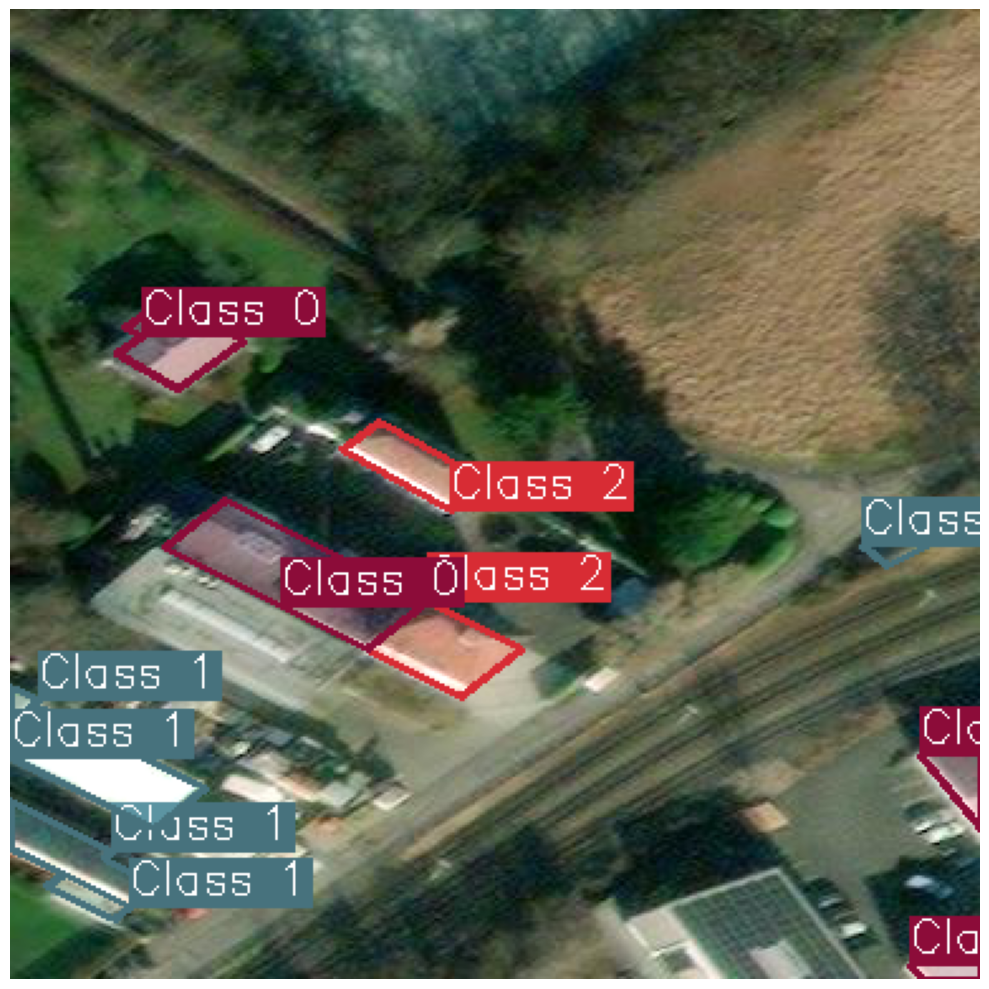

In [33]:
a = visualize_yolo_polygons(image_path = "datasets/bonn_dataset_shape_70/images/train/patch_25056_22176_aug0.png", label_path = "datasets/bonn_dataset_shape_70/labels/train/patch_25056_22176_aug0.txt", show=True)

#### Step 3: Model Training
In this step, we fine-tune the pre-trained [Ultralytics YOLOv11](https://docs.ultralytics.com/models/yolo11/) instance segmentation model on our curated roof material dataset.

YOLOv11 supports instance segmentation natively, allowing the model to learn both **which type of roof material is present** and **where it appears** in the image. By leveraging a model pre-trained on large-scale visual datasets, we benefit from transfer learning: the network has already learned general visual patterns (e.g., edges, shapes, textures), and we now adapt it to the specific task of **roof material classification from aerial imagery**.

The training process involves:

- Specifying the `roof_materials.yaml` file, which defines paths to training/validation/test sets and maps class indices to material names.
- Loading the pre-trained weights (e.g., `yolo11s-seg.pt`) as a starting point.
- Running the model over several epochs while monitoring training and validation metrics (loss, segmentation mAP, etc.).

We use Ultralytics' Python interface to launch training, configure hyperparameters, and log progress.

Model citation:
@software{yolo11_ultralytics,
  author = {Glenn Jocher and Jing Qiu},
  title = {Ultralytics YOLO11},
  version = {11.0.0},
  year = {2024},
  url = {https://github.com/ultralytics/ultralytics},
  orcid = {0000-0001-5950-6979, 0000-0002-7603-6750, 0000-0003-3783-7069},
  license = {AGPL-3.0}
}

In [44]:
model = YOLO('yolo11s-seg.pt')

results = model.train(
    data='datasets/final_roof_material_dataset/roof_materials.yaml',
    epochs=135,
    imgsz=384,
    batch=16,
    plots=True,
    device='0',
    pretrained=True,
    patience=20,
    save_period=10,
    name=f'run_materials'
)

New https://pypi.org/project/ultralytics/8.3.111 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.100 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40326MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=datasets/final_roof_material_dataset/roof_materials.yaml, epochs=135, time=None, patience=20, batch=16, imgsz=384, save=True, save_period=10, cache=False, device=0, workers=8, project=None, name=run_materials3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, r

train: Scanning /home/ubuntu/roofmap_project/datasets/final_roof_material_dataset/labels/train... 625 images, 0 backgrou

train: WARNING ⚠️ /home/ubuntu/roofmap_project/datasets/final_roof_material_dataset/images/train/patch_21312_18720_aug0.png: ignoring corrupt image/label: negative label values [-0.0012735]
train: WARNING ⚠️ /home/ubuntu/roofmap_project/datasets/final_roof_material_dataset/images/train/patch_21312_18720_aug1.png: ignoring corrupt image/label: negative label values [-0.0012735]
train: WARNING ⚠️ /home/ubuntu/roofmap_project/datasets/final_roof_material_dataset/images/train/patch_26208_21312_aug1.png: ignoring corrupt image/label: negative label values [-0.0001665]


train: New cache created: /home/ubuntu/roofmap_project/datasets/final_roof_material_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/ubuntu/roofmap_project/datasets/final_roof_material_dataset/labels/val.cache... 111 images, 0 backgr


Plotting labels to /home/ubuntu/roofmap_project/runs/segment/run_materials3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 384 train, 384 val
Using 8 dataloader workers
Logging results to /home/ubuntu/roofmap_project/runs/segment/run_materials3
Starting training for 135 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/135      2.22G      2.955      4.407      2.905      1.867        458        384: 100%|██████████| 39/39 [00:05<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.211      0.115     0.0393      0.014      0.209     0.0529     0.0284    0.00862



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/135      2.56G      2.231      3.592      1.877      1.377        467        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704     0.0785      0.153     0.0702     0.0314      0.076      0.144     0.0604     0.0216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/135      2.56G      2.123       3.43      1.766      1.306        336        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.458     0.0799     0.0745     0.0308      0.418     0.0703     0.0602     0.0228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/135      2.56G      2.017       3.34      1.673      1.273        325        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.239      0.242      0.196      0.111      0.219       0.23      0.181     0.0857



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/135       2.6G      1.959      3.275      1.576      1.249        511        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.589      0.238      0.232       0.13       0.57      0.231      0.219     0.0956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/135      2.62G      1.892      3.201      1.551      1.224        218        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704       0.65      0.228      0.238      0.119      0.618      0.216      0.221      0.102

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/135      2.69G      1.878      3.121       1.52      1.211        453        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.368      0.276      0.251      0.147      0.342      0.257      0.234      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/135      2.73G      1.863      3.123       1.47      1.194        407        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.564      0.258      0.232      0.146      0.543      0.246      0.221      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/135      2.74G      1.801      3.066      1.416      1.191        577        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.509      0.228      0.236      0.138      0.483      0.219       0.22      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/135      2.74G       1.75      2.948      1.374      1.159        325        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.698       0.28       0.27      0.167      0.667      0.257      0.248      0.124



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/135      2.74G      1.772      2.991      1.387      1.159        274        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.724      0.212      0.201      0.114      0.676        0.2      0.182     0.0927



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/135      2.74G      1.701      2.892       1.35       1.15        442        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704      0.702       0.18      0.221      0.137      0.698      0.176      0.209      0.105

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/135      2.74G      1.703      2.866       1.32       1.15        334        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.513      0.251      0.251      0.151      0.523      0.214      0.238      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/135      2.74G      1.678      2.862      1.305      1.139        287        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704      0.201      0.251      0.229       0.14      0.449      0.178       0.21      0.111

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/135      2.74G      1.678      2.864      1.317      1.136        328        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704      0.146      0.208      0.171     0.0836      0.207      0.132      0.154     0.0733

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/135      2.74G      1.666      2.806      1.289      1.121        216        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704      0.501      0.229      0.244      0.144      0.468      0.222      0.232      0.114

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/135      2.78G      1.638      2.782      1.246      1.108        437        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.603      0.265      0.249      0.154      0.582      0.253      0.233      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/135      2.78G       1.62      2.755      1.261      1.114        420        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704      0.302      0.272      0.263       0.16       0.29      0.257      0.245      0.131

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/135      2.78G      1.612      2.749      1.213      1.101        485        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.528       0.22      0.248      0.161      0.495      0.206      0.231      0.129



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/135      2.78G      1.622      2.733       1.21       1.11        403        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704      0.844      0.208      0.258      0.157      0.853      0.202      0.243      0.124

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/135      2.78G      1.604      2.718      1.232      1.092        415        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.589      0.258      0.274      0.178      0.586      0.256      0.258      0.144



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/135      2.78G      1.573      2.671      1.178      1.082        369        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.715      0.233      0.285      0.174      0.754       0.19      0.263      0.137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/135      2.78G      1.571      2.674      1.181      1.079        289        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.514      0.255      0.279      0.175      0.421      0.234      0.237      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/135      2.78G      1.524      2.601      1.133      1.074        266        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.692      0.255      0.299      0.185      0.641      0.253      0.283      0.151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/135      2.78G      1.531      2.593      1.145      1.061        445        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.587      0.274      0.306      0.168      0.578       0.27      0.293      0.141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/135      2.78G      1.538      2.606      1.166      1.087        413        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.354      0.276      0.298      0.195      0.334      0.263      0.284      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/135      2.78G      1.545      2.632      1.155      1.073        464        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704      0.486       0.35      0.316      0.202      0.473      0.333      0.301      0.145

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/135      2.78G      1.568      2.665      1.175      1.077        246        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.329      0.312      0.286      0.187      0.307      0.303      0.273      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/135      2.78G      1.514      2.572      1.132      1.064        387        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.565      0.243      0.274      0.166      0.544      0.233       0.26      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/135      2.78G      1.511      2.566      1.116      1.064        272        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.506      0.302      0.288      0.175      0.485      0.293      0.261      0.128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/135      2.78G      1.488      2.524      1.122      1.058        334        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.493      0.367      0.326       0.21       0.48       0.36      0.316      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/135      2.78G      1.486      2.518      1.116      1.063        301        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.494      0.293      0.377      0.227      0.528      0.266      0.361      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/135      2.78G      1.458      2.522      1.071      1.044        378        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.475      0.311      0.353      0.224      0.499      0.282      0.318      0.172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/135      2.78G      1.474      2.518      1.091      1.041        332        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.538      0.264      0.284       0.18      0.517       0.25      0.255      0.141



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/135      2.78G      1.481      2.547      1.099      1.062        381        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.285      0.369      0.317        0.2      0.258      0.325      0.277      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/135      2.78G       1.47      2.477      1.076      1.046        370        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.544      0.353      0.379      0.247      0.534      0.346      0.368      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/135      2.78G      1.465      2.483      1.082       1.06        391        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.523      0.263      0.276      0.177        0.5      0.252      0.258      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/135      2.78G      1.453      2.446      1.066       1.04        376        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.365      0.298      0.287      0.186      0.349      0.292      0.276      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/135      2.78G      1.447       2.48      1.059      1.044        464        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704       0.37      0.377      0.327      0.205      0.358      0.367      0.311      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/135      2.78G      1.443      2.447      1.048      1.041        400        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.379      0.315      0.321      0.196      0.439      0.279      0.304      0.151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/135      2.82G      1.444      2.412      1.043      1.039        417        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.447      0.323      0.331      0.214      0.441      0.311      0.333      0.159



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/135      2.82G      1.404       2.38      1.023      1.028        276        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.717       0.28      0.308      0.194      0.371       0.31      0.278      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/135      2.82G      1.425      2.427      1.042      1.038        411        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.603      0.305      0.311        0.2      0.585       0.29      0.295      0.148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/135      2.82G       1.41      2.382      1.018      1.025        471        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.443      0.326        0.3      0.193      0.422       0.31      0.281      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/135      2.82G      1.388      2.365      1.004      1.025        330        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.447      0.269      0.271      0.172      0.426      0.257      0.256      0.139



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/135      2.82G      1.388      2.381      1.025      1.022        391        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.565      0.313      0.327      0.213      0.547      0.301      0.293      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/135      2.82G      1.416      2.389      1.013      1.025        283        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.423       0.32      0.307      0.204      0.405      0.314      0.292      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/135      2.82G      1.377      2.333     0.9918      1.013        384        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.778       0.29      0.341      0.232      0.762      0.281      0.325      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/135      2.82G      1.361      2.312     0.9795       1.01        507        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.743      0.326      0.339      0.225      0.762      0.305      0.321      0.166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/135      2.82G      1.369      2.314     0.9834      1.011        319        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.661      0.318       0.36      0.223      0.647      0.308      0.346      0.171



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/135      2.82G      1.357      2.312     0.9901      1.015        483        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.654      0.296      0.333      0.212      0.628      0.288      0.316       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/135      2.82G      1.356       2.34     0.9905      1.007        484        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.769      0.338      0.346      0.228      0.754      0.321      0.329      0.157



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/135      2.82G      1.353      2.307     0.9732      1.008        420        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.479      0.378      0.366      0.236       0.47      0.364       0.35      0.184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/135      2.82G      1.393      2.344      0.988      1.013        340        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.563      0.376      0.384      0.251      0.558      0.365      0.371      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/135      2.82G       1.35      2.282     0.9712      1.011        431        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.719      0.364      0.386      0.264      0.705      0.356      0.372      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/135      2.82G      1.318      2.268      0.944     0.9921        325        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.357      0.361      0.346      0.224      0.339      0.348      0.328      0.183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/135      2.82G      1.354      2.289     0.9566     0.9968        283        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.703      0.299      0.334      0.204      0.686      0.292      0.321      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/135      2.82G      1.346      2.272     0.9486      1.003        333        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.591      0.357       0.34       0.22      0.578      0.343      0.324      0.168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/135      2.82G      1.351      2.312     0.9424     0.9948        372        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.697      0.342      0.378      0.246      0.684      0.332      0.362      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/135      2.82G      1.312      2.235     0.9261     0.9942        344        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704       0.71      0.323      0.338      0.218      0.693      0.317      0.327      0.173



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/135      2.82G      1.307      2.238     0.9301      0.993        513        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.455      0.393      0.366      0.258      0.622      0.374      0.353      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/135      2.82G      1.307      2.223      0.923     0.9912        415        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.442      0.338      0.325      0.217       0.43      0.323       0.31      0.161



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/135      2.82G      1.305      2.212     0.9269     0.9973        362        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.688      0.336      0.368      0.246      0.683       0.33      0.355      0.195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/135      2.82G      1.296      2.196     0.9086     0.9859        307        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.692      0.351      0.368      0.245      0.698      0.343      0.354      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/135      2.82G      1.305      2.198     0.9238     0.9838        348        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.629      0.339      0.357       0.24      0.615      0.328      0.344       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/135      2.82G      1.284      2.185     0.9034     0.9834        379        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.612      0.373      0.384      0.252      0.596      0.359      0.366      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/135      2.82G      1.282      2.196     0.9017     0.9831        423        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.542      0.337       0.35       0.23      0.699      0.325      0.333      0.176



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/135      2.82G      1.282      2.192     0.8975     0.9839        293        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.644      0.346      0.372      0.241       0.64      0.337       0.36      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/135      2.82G      1.268      2.162     0.8905     0.9848        415        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.494       0.33       0.37      0.225      0.481      0.314       0.34      0.165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/135      2.82G      1.291      2.188     0.9048     0.9794        595        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.524      0.375      0.376      0.251      0.506      0.364      0.358      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/135      2.82G      1.282      2.176     0.8932     0.9792        446        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.717      0.353      0.384      0.252      0.688      0.341      0.366        0.2



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/135      2.82G      1.277      2.166     0.9003     0.9763        326        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.752      0.373      0.382      0.259      0.758       0.36      0.371      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/135      2.82G       1.26      2.178     0.8811     0.9784        384        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704       0.39      0.364      0.377       0.26      0.561      0.348      0.363      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/135      2.82G      1.262       2.16     0.8873     0.9758        291        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.714      0.343      0.377      0.256      0.708      0.337      0.366      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/135      2.82G      1.266      2.157     0.9046     0.9816        225        384: 100%|██████████| 39/39 [00:04<
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

                   all        111       2704      0.669      0.363      0.374      0.246      0.665      0.356      0.363      0.192
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 55, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



75 epochs completed in 0.125 hours.
Optimizer stripped from /home/ubuntu/roofmap_project/runs/segment/run_materials3/weights/last.pt, 20.5MB
Optimizer stripped from /home/ubuntu/roofmap_project/runs/segment/run_materials3/weights/best.pt, 20.5MB

Validating /home/ubuntu/roofmap_project/runs/segment/run_materials3/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40326MiB)
YOLO11s-seg summary (fused): 113 layers, 10,069,525 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP5


                   all        111       2704       0.72      0.364      0.384      0.261      0.706      0.356       0.37      0.204
            roof_tiles        100       1829      0.716       0.73      0.721      0.454      0.708      0.721      0.707      0.368
             tar_paper         81        825      0.408      0.191      0.187     0.0658      0.326      0.153      0.129     0.0328
                 metal         11         32      0.601     0.0625     0.0847     0.0561      0.601     0.0625     0.0725      0.043
              concrete          1          2          1          0          0          0          1          0          0          0
                gravel          1         10      0.812      0.866      0.884       0.69      0.812      0.866      0.884      0.515
                 glass          5          6      0.786      0.333      0.426      0.302      0.788      0.333      0.426      0.265
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 4.4ms postproce

#### Next Steps + Potential Improvements

- Experimenting with smaller patch sizes to decrease the amount of patches with unlabelled houses
- Training using a custom model architecture
- Applying data augmentation to balance out the 
- Creating a pipeline that works for areas with sparse/non-grouped labels such as Nepal, Mozambique, Sri Lanka, and India. This was the initial goal but we realized data quality was subpar, so we pivoted to creating a reproducible pipeline in a data-rich area that could later be applied to other areas.
- Creating a pipeline that works for medium-high resolution satellite imagery
- Provide model checkpoints
- Evaluation and inference on nearby areas in Germany to expand available data
- Manually validating test set data
- Create roof shape dataset